In [0]:
try:
  %tensorflow_version 1.x  # Colab only.
except Exception:
  pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x  # Colab only.`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
import tensorflow as tf
import pandas as pd
import os
import zipfile
import numpy as np
import cv2
import tqdm
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
import h5py
print('using tensorflow version',tf.__version__)
from time import time


using tensorflow version 1.14.0


Using TensorFlow backend.


**Download  and extract data**

In [0]:
!wget --no-check-certificate https://he-public-data.s3-ap-southeast-1.amazonaws.com/HE_Challenge_data.zip -O /tmp/HE_Challenge_data.zip

--2019-08-13 06:16:58--  https://he-public-data.s3-ap-southeast-1.amazonaws.com/HE_Challenge_data.zip
Resolving he-public-data.s3-ap-southeast-1.amazonaws.com (he-public-data.s3-ap-southeast-1.amazonaws.com)... 52.219.40.7
Connecting to he-public-data.s3-ap-southeast-1.amazonaws.com (he-public-data.s3-ap-southeast-1.amazonaws.com)|52.219.40.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 948965311 (905M) [application/zip]
Saving to: ‘/tmp/HE_Challenge_data.zip’

/tmp/HE_Challenge_d 100%[===================>] 905.00M  8.31MB/s    in 1m 59s  

2019-08-13 06:18:57 (7.63 MB/s) - ‘/tmp/HE_Challenge_data.zip’ saved [948965311/948965311]



In [0]:
local_zip = '//tmp/HE_Challenge_data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/flower_data')
zip_ref.close()

**Variables to be used in code**

In [0]:
data_dir = '/tmp/flower_data/data'
# os.listdir(data_dir)
train_dir = os.path.join(data_dir, 'train')
# os.listdir(train_dir)
test_dir = os.path.join(data_dir, 'test')
# os.listdir(test_dir)
train_csv = os.path.join(data_dir, 'train.csv')
test_csv = os.path.join(data_dir, 'test.csv')
submission_csv =  os.path.join(data_dir, 'sample_submission.csv')
#Save model checkpoints
model_dir="/tmp/flower_data/models"
#catc exeption and move on if file already exists
try: 
    os.mkdir(model_dir) 
except OSError as error: 
    print(error)  

[Errno 17] File exists: '/tmp/flower_data/models'


In [0]:
#for using tensorlow backend with keras
K.set_image_data_format('channels_last')
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 3
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)
NUM_CLASSES = 102
modelpath = os.path.join(model_dir,"final_model.hdf5")
EPOCHS=30

**Creating  a separate validation data with every tenth image and correponding label**




In [0]:


#train_fnames -> filenames of training data
#val_fnames -> filenames of validation data

train_data = pd.read_csv(train_csv)
train_fnames = train_data['image_id']
print ('Total Images -> ',len(train_fnames))
val_fnames = train_fnames[::10]
val_fnames = list(val_fnames)
train_fnames = list(train_fnames)
del train_fnames[0::10]
print('Total training images: ',len(train_fnames))
print('Total validation images: ',len(val_fnames))

#train_labels -> list of labels for training
#val_labels -> list of labels for validation
train_labels = train_data['category']
val_labels = train_labels[::10]
val_labels = list(val_labels)
train_labels = list(train_labels)
del train_labels[0::10]
# print(len(val_fnames))
# print(len(train_fnames))


Total Images ->  18540
Total training images:  16686
Total validation images:  1854


**Functions for data creation**

In [0]:

def create_filepaths(base_path,filenames):
  filepaths=[]
  for filename in  filenames:
    filepath = os.path.join(base_path,str(filename)+'.jpg')
    filepaths.append(filepath)
  return filepaths

def read_data(filepaths,labels):
    
    N_total = len(filepaths)
    X = np.zeros((N_total,) + INPUT_SHAPE)
    y = np.zeros((N_total,))
    for i in range(len(filepaths)):
        img=cv2.imread(filepaths[i])
        img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
        img = img *1.0/255
        X[i,:,:,:] = img
        #Since the labels here are from 1 to 102 but to categorical requires 0-101
        y[i] = int(labels[i]) - 1
        Y = np_utils.to_categorical(y,NUM_CLASSES)
    return (X,Y)
    

In [0]:
#Read image files for training
train_filepaths = create_filepaths(train_dir,train_fnames)
print (len(train_filepaths))


16686


In [0]:
#Read image files for  validation
val_filepaths = create_filepaths(train_dir,val_fnames)
# print (val_filepaths)


Display 1 image to see how data looks like


(224, 224, 3)


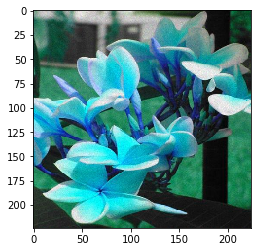

In [0]:
#Display an image to test 
import matplotlib.pyplot as plt
img=cv2.imread(train_filepaths[0])
img = img *1.0/255
img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
print(img.shape)
plt.imshow(img)
plt.show()


**Create training and validation Data **

In [0]:
#Return training image tensors
X_train,Y_train = read_data(train_filepaths,train_labels)

In [0]:
X_val, Y_val = read_data(val_filepaths,val_labels)

In [0]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(16686, 224, 224, 3)
(16686, 102)
(1854, 224, 224, 3)
(1854, 102)


**Create Model for Training**

**Trying Transfer learning**

In [0]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
# local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# base_model = InceptionV3(input_shape = (224, 224, 3), 
#                                 include_top = False, 
#                                 weights = 'imagenet')
base_model = tf.keras.applications.VGG19(weights = "imagenet", include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))


# pre_trained_model.load_weights(local_weights_file)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(102, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='RMSprop', loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

W0813 06:21:00.060854 140269634074496 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
#  layer names with layer indices in base model
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool


In [0]:

        
def lr_schedule(epoch):
  """
  Returns a custom learning rate that decreases as epochs progress.
  """
  learning_rate = 0.2
  if epoch > 10:
    learning_rate = 0.02
  if epoch > 20:
    learning_rate = 0.001
  if epoch > 50:
    learning_rate = 0.001
  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
#Did not use save_best_only =TRue as it is buggy and crashes.
checkpoint = tf.keras.callbacks.ModelCheckpoint(modelpath,monitor="val_acc",verbose=1,mode="max")
callbacks_list=[checkpoint]


In [0]:
# Create a TensorBoard instance with the path to the logs directory
history=model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=EPOCHS,callbacks=callbacks_list)

Train on 16686 samples, validate on 1854 samples
Epoch 1/30
16672/16686 [============================>.] - ETA: 0s - loss: 2.6642 - acc: 0.3782
Epoch 00001: saving model to /tmp/flower_data/models/final_model.hdf5
16686/16686 [==============================] - 119s 7ms/sample - loss: 2.6637 - acc: 0.3783 - val_loss: 1.6926 - val_acc: 0.5647
Epoch 2/30
16672/16686 [============================>.] - ETA: 0s - loss: 1.2643 - acc: 0.6660
Epoch 00002: saving model to /tmp/flower_data/models/final_model.hdf5
16686/16686 [==============================] - 113s 7ms/sample - loss: 1.2638 - acc: 0.6661 - val_loss: 1.1587 - val_acc: 0.6877
Epoch 3/30
16672/16686 [============================>.] - ETA: 0s - loss: 0.9072 - acc: 0.7524
Epoch 00003: saving model to /tmp/flower_data/models/final_model.hdf5
16686/16686 [==============================] - 115s 7ms/sample - loss: 0.9072 - acc: 0.7524 - val_loss: 0.9767 - val_acc: 0.7114
Epoch 4/30
16672/16686 [============================>.] - ETA: 0s - l

**PLot Accuracy**

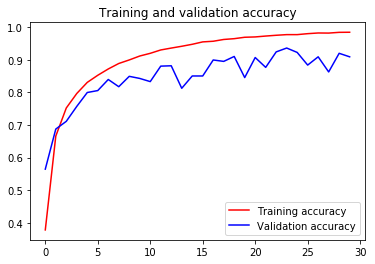

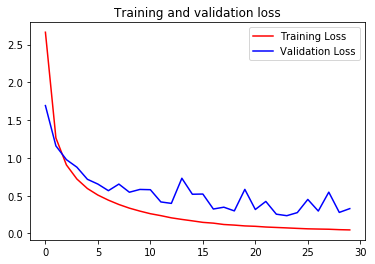

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**FIne Tune the model for better accuracy**
Uncomment the following code for fine tuning the VGG-16 model
It has been commented out because aleady the model gives decent accuracy without fine tuning

In [0]:
# # we chose to train the top 2 inception blocks, i.e. we will freeze
# # the first 249 layers and unfreeze the rest:
# #We freeze first five layers of vgg16 net and train the rest
# for layer in model.layers[:5]:
#    layer.trainable = False
# for layer in model.layers[5:]:
#    layer.trainable = True
    
# # we need to recompile the model for these modifications to take effect
# # we use RMSProp with a low learning rate
# from tensorflow.keras.optimizers import RMSprop
# model.compile(optimizer=RMSprop(lr=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

**Train after fine tuning**

In [0]:
# history=model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=60,callbacks=callbacks_list)

**No Transfer learning Approach** 
Tested accuracy: 75%
This a CNN model with % convolution and 2 FC Layers with around an accuracy of 75%. Comment the Transfer learning part and incomment the cell below fpor training the same

In [0]:
# model = tf.keras.models.Sequential([
#     # This is the first convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS)),
#     tf.keras.layers.MaxPooling2D(2, 2),
# #     # The second convolution
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
# #     # The third convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
# #     # The fourth convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
# #     # The fifth convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # Flatten the results to feed
#     tf.keras.layers.Flatten(),
#     # 512 neuron hidden layer
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.Dense(256, activation='relu'),
#      tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(102, activation='softmax')
# ])

In [0]:
# model.summary()

**Train Model**

In [0]:
# model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
# history=model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=40)

**Visualize Training/ validation losses and accuracies**

In [0]:
# import matplotlib.pyplot as plt
# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()

# plt.plot(epochs, loss, 'r', label='Training Loss')
# plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()

**Test model on DATA**

Relevant functions for testing

In [0]:
#Create test data from images
def load_test_image_data(filepaths):
  N_total = len(filepaths)
  X = np.zeros((N_total,) + INPUT_SHAPE)
  for i in range(len(filepaths)):
    img=cv2.imread(filepaths[i])
    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = img *1.0/255
    X[i,:,:,:] = img
  return X

def predict_test_labels(filepaths):
  X=load_test_image_data(filepaths)
  model = tf.keras.models.load_model(modelpath)
  Y_prob=model.predict(X)
  Y=np.argmax(Y_prob,axis=1)
  #realign labels to 1-102(as in test.csv) instead of 0-101 (as given by model.predict)
  Y=Y+1
  return Y

def create_file_pathfrom_csv(test_csv):
  test_data = pd.read_csv(test_csv)
  test_fnames = test_data['image_id']
  test_fnames.head()
  test_filepaths = create_filepaths(test_dir,test_fnames)
  test_filepaths
  test_filepaths[0]
  return test_filepaths

def create_submission_csv(submission_csv,label_vector):
    submission_t_csv =  os.path.join(data_dir, 'sample_submission_test.csv')
    df=pd.read_csv(submission_csv)
    ids=df['image_id']
    ids= np.asarray(ids)
    ids= ids.reshape(ids.shape[0],1)
    label_vector=label_vector.reshape(label_vector.shape[0],1)
    csv_data = np.concatenate((ids,label_vector),axis=1)
    print ('csv_shape is:',csv_data.shape)
    np.savetxt(submission_csv,csv_data,delimiter=',',fmt='%d')

**Create Testing Data**

In [0]:
X_train=Y_train=X_val=Y_val=[]

In [0]:

test_filepaths = create_file_pathfrom_csv(test_csv)


In [0]:
Y = predict_test_labels(test_filepaths)


**Save test  results to submission_test.csv**

In [0]:
create_submission_csv(submission_csv,Y)

csv_shape is: (2009, 2)


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')